### Assignment 16

100 images of size 400x400 are annotated by VIA tool and saved in json file.
Used K-means clustering to find out the top 4 anchor boxes



In [1]:
import json
import numpy as np
import sys, os
%matplotlib inline
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/gdrive')
dir = "/content/gdrive/My Drive/Colab Notebooks/EVA/Session16/"

!ls
#os.chdir('/content')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
gdrive	images	sample_data


#### Reading the Json file having the dimensions of the bounding boxes of the annotated images.

In [0]:
data=[]

# data of type dic
with open(dir + "face_annotations.json", "r") as read_file:
    data = json.load(read_file)

#### Extracting bounding box attributes 'width' and 'height'

In [4]:
X = []

imgd = data['_via_img_metadata']

for key, imgval in imgd.items():
    for regs in imgval['regions']:
        shape = regs['shape_attributes']
        X.append([shape['width'], shape['height']])

# X is list of lists -> converted to ndarray of shape(155,2)
X = np.reshape(X, (-1, 2))
print(X[:2] )

X = X/400
log_X = np.log(X)
print(log_X[:2] )

[[ 76 150]
 [ 42 125]]
[[-1.66073121 -0.98082925]
 [-2.25379493 -1.16315081]]


#### Plotting the attributes

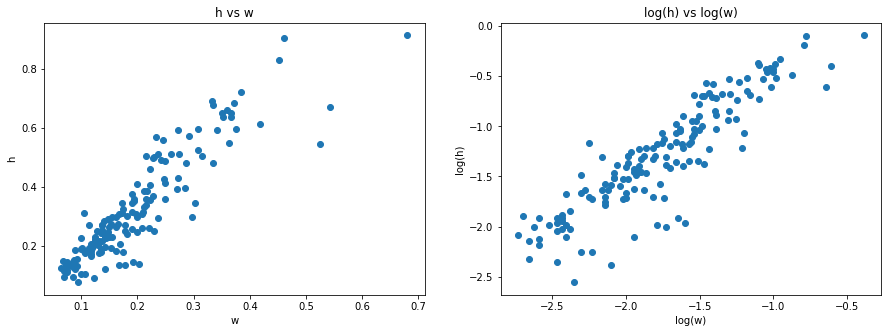

In [5]:
fig, axs = plt.subplots(1,2,figsize=(15,5))

axs[0].plot(X[:, 0], X[:, 1], 'o')
axs[0].set_title('h vs w')
axs[0].set_ylabel('h')
axs[0].set_xlabel('w')

axs[1].plot(log_X[:, 0], log_X[:, 1], 'o')
axs[1].set_title('log(h) vs log(w)')
axs[1].set_ylabel('log(h)')
axs[1].set_xlabel('log(w)')
plt.show()

#### Run K-means cluster on the points with k=4

In [6]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4, init="k-means++", n_init=10, max_iter=300, tol=0.0001).fit(X)
lkmeans = KMeans(n_clusters=4, init="k-means++", n_init=10, max_iter=300, tol=0.0001).fit(log_X)

y_pred, log_ypred = kmeans.predict(X), lkmeans.predict(log_X)
print(y_pred.shape, y_pred[:10])

(155,) [0 0 3 1 0 0 2 2 0 0]


#### Plot points in different clusters, visualised as diff colors

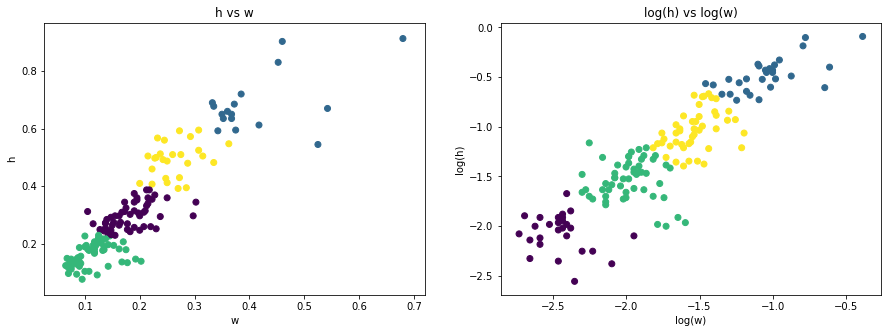

In [7]:
fig, axs = plt.subplots(1,2,figsize=(15,5))

axs[0].scatter(X[:, 0], X[:, 1], c=y_pred)
axs[0].set_title('h vs w')
axs[0].set_ylabel('h')
axs[0].set_xlabel('w')

axs[1].scatter(log_X[:, 0], log_X[:, 1], c=log_ypred)
axs[1].set_title('log(h) vs log(w)')
axs[1].set_ylabel('log(h)')
axs[1].set_xlabel('log(w)')
plt.show()

#### Choosing the Best Boxes - $log(w)$ vs $log(h)$ association being equi-spaced, is ideal to take up the centroid of the k-means clusters for the final bounding box.

Get (w, h) of cluster centers

In [8]:
kmeans.cluster_centers_*400

cluster_center = np.exp(lkmeans.cluster_centers_)*400
cluster_center

array([[ 34.46274586,  50.52641898],
       [140.74302088, 246.3266109 ],
       [ 55.20125031,  86.17345379],
       [ 86.13061342, 141.28542166]])

## Visualization

Few images are selected, and superimposed with the computed bounding box. 

In [9]:
import cv2
from os import listdir
from os.path import join
import matplotlib.patches as patches

!unzip -qq "/content/gdrive/My Drive/Colab Notebooks/EVA/Session16/images.zip"
!pwd
!ls -al images/img_050.jpg

replace images/img_001.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
/content
-rw-r--r-- 1 root root 51455 Nov 19 15:31 images/img_050.jpg


In [0]:
# cluster_center - coordinates of 4 cluster centers
def plot_image(imgd, img_idx, cluster_center):  
    # first key is img_001.jpg66268
    key = list(imgd.keys())[img_idx]
    imgval = imgd[key]
    
    path = join("images", imgval["filename"])
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    fig = plt.gcf()
    fig.set_size_inches(12, 12)
    plt.imshow(img)
    ax = fig.get_axes()[0]
    
    # for each annotated box / face
    for regs in imgval['regions']:
        shape = regs['shape_attributes']
        
        # (x,y) are coordinates top-left point
        x, y, w, h = shape['x'], shape['y'], shape['width'], shape['height']
        
        # Annotated bounding box plotted in yellow
        rect = patches.Rectangle((x, y), w, h, linewidth=4, edgecolor='y', facecolor='none')
        ax.add_patch(rect)
        
        # Center of annotated bounding box
        bb_center_x, bb_center_y = (x + w/2), (y + h/2)
        
        # Bounding boxes from 4 clusters plotted in red, green, blue, cyan
        cluster_cnt = len(cluster_center)
        color = ['r', 'g', 'b', 'c']        
        
        # Bounding boxes from 4 clusters computed (cluster centroids taken as the centroid of the annotated BB)
        for i in range(cluster_cnt):
            w, h = cluster_center[i, 0], cluster_center[i, 1]
            x, y = bb_center_x - w/2, bb_center_y - h/2
            rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor=color[i], facecolor='none')
            ax.add_patch(rect)
    plt.show()

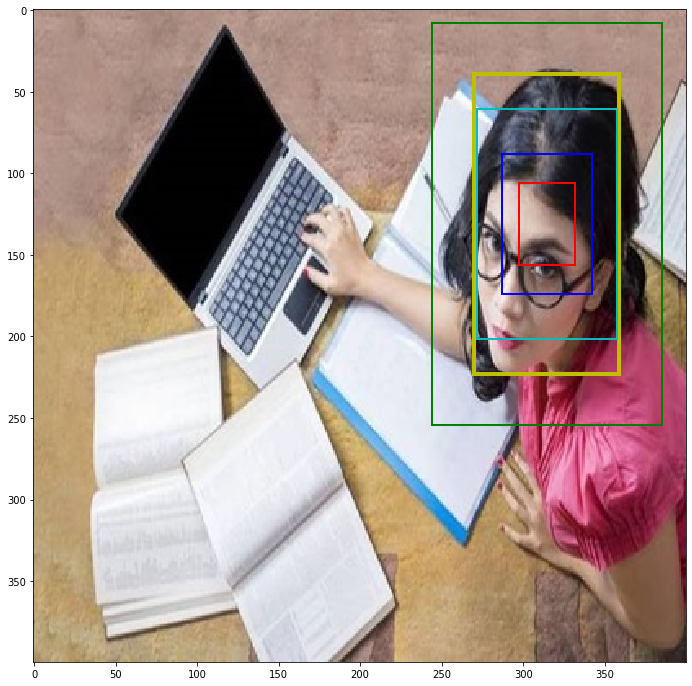

In [11]:
plot_image(imgd, 1, cluster_center)

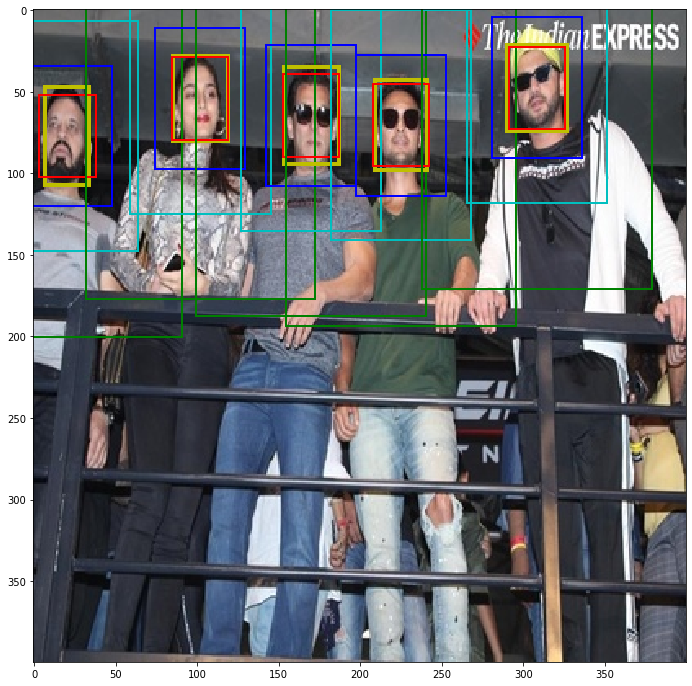

In [12]:
plot_image(imgd, 15, cluster_center)

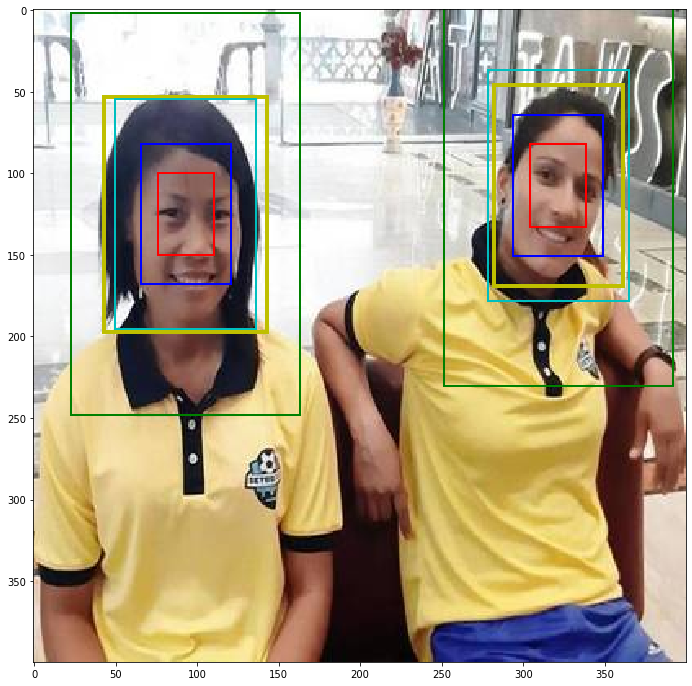

In [13]:
plot_image(imgd, 37, cluster_center)

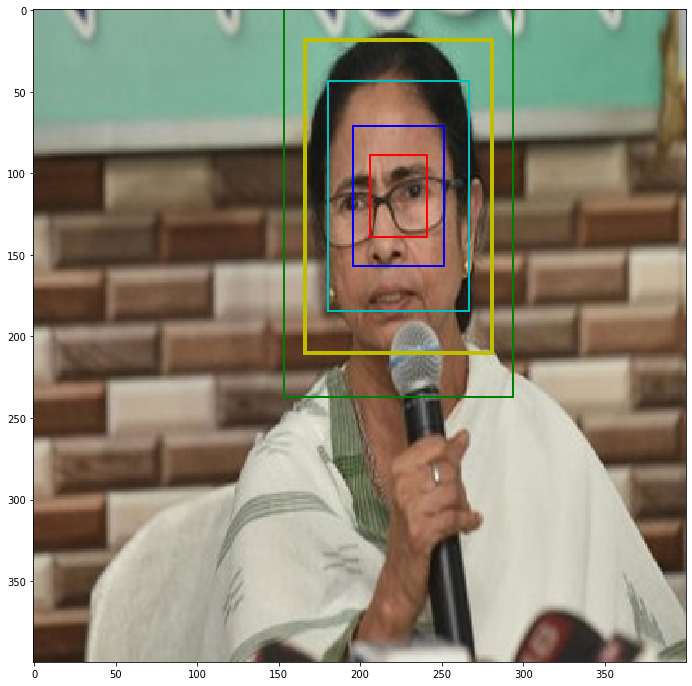

In [14]:
plot_image(imgd, 92, cluster_center)